 ### Python scripts used for the paper entitled:
 #### Single character insertion-deletion model preserves long indels in ancestral sequence reconstruction

In [ ]:
## Python 3
# Acc of ARPIP inference on simulated data
# Created by:  Gholamhossein Jowkar <jowk@zhaw.ch>
# ACGT ZHAW
# Created date: Nov 2023
# Modified by: jowk
# Modified date: 


Importing the library used here:

In [1]:

import os, sys, time, statistics, json, re, fnmatch, math
from collections import Counter
from statistics import mean

from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment

# from ete3 import Tree

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc

path = "./" #set path to the simulated data directory/dataset
os.chdir(path)

# Setting the styles
sns.set_style('white')
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
color_1 = sns.color_palette()[0]
color_2 = sns.color_palette()[1]

#### Roc Curve: ARPIP ASR vs. INDELible true ancestral values

In [ ]:
#*****************************************************************
#----------------------- Define functions ------------------------
#*****************************************************************
def get_zero_one_matrix(alignment):
    """
    0/1 mapping of sequence for gap/non-gap characters
    """
    # Get the dimensions of the alignment
    num_sequences = len(alignment)
    alignment_length = alignment.get_alignment_length()

    # Create an empty NumPy array to store the 0 and 1 matrix
    matrix = np.zeros((num_sequences, alignment_length), dtype=int)

    # Iterate through the alignment and convert characters to 0 and 1
    for i, record in enumerate(alignment):
        for j, char in enumerate(record.seq):
            if char == '-':
                matrix[i, j] = 1  # Gap character
            else:
                matrix[i, j] = 0  # Non-gap character
    return matrix




#*****************************************************************
#--------------------------- Main code ---------------------------
#*****************************************************************

vec_indelible = np.empty((0,))
vec_arpip = np.empty((0,))
dict_fpr_tpr = {}
lst_fpr = []
lst_tpr = []

cnt=0

for file in os.listdir(''):#set direction to indelible directory
    if file.endswith('_TRUE.fas'):
        file_name = file.split('_')[0]

        # Load your MSA file (replace 'your_msa_file.fasta' with your file's path)
        indelible_aln = AlignIO.read(f"./{file_name}_indelible_ANCESTRAL.fas", "fasta")
        arpip_aln = AlignIO.read(f"./indelible_{file_name}.arpipasr.fasta", "fasta")
        
        # Read the input sequence for INDELible AS
        if indelible_aln.get_alignment_length() != arpip_aln.get_alignment_length():
            print(file_name)
            print("The length of indelible is %s while %s for ARPIP" %(indelible_aln.get_alignment_length(), arpip_aln.get_alignment_length()))
        
        #-------------------- gap acc ---------------------
        mtx_true_indelible = get_zero_one_matrix(indelible_aln)     
        vec_indelible = np.concatenate((vec_indelible, mtx_true_indelible.flatten()))
        
        mtx_inf_arpip = get_zero_one_matrix(arpip_aln)
        vec_arpip = np.concatenate((vec_arpip, mtx_inf_arpip.flatten()))
        
        loc_fpr, loc_tpr, thresholds = roc_curve(mtx_true_indelible.flatten(), mtx_inf_arpip.flatten())
        a = loc_fpr[1]
        b = loc_tpr[1]
        lst_fpr.append(a)
        lst_tpr.append(b)
        dict_fpr_tpr[file_name] = [a, b]


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(vec_indelible, vec_arpip)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



In [3]:
path = "./simulation_data/" #set path to the simulated data directory/feature directory
os.chdir(path)

# write the df_fpr_tpr dataframe
df_fpr_tpr = pd.DataFrame.from_dict(dict_fpr_tpr, columns=['fpr', 'tpr'], orient='index')
df_fpr_tpr.to_csv('./01_fpr_tpr_sklearn.csv')
print("Done")

Done


In [4]:
# df_acc = pd.read_csv('./01_fpr_tpr_sklearn.csv')
df_acc = pd.read_csv('./01_acc_pr_oma_df.csv')

df_acc = df_acc[df_acc['is gappy']==1]
df_roc = df_acc[['recall', 'specificity']]

df_roc = df_roc[df_roc['recall'] != 0]
df_roc = df_roc[df_roc['specificity'] != 0]
# print(len(df_roc))

df_roc['fpr'] = 1-df_roc['specificity']
# print(df_roc['fpr'])

df_roc['tpr'] = df_roc['recall']

# Sort DataFrame by the 'Age' column in descending order
df_roc.sort_values(by='fpr', inplace=True)
# print(df_roc['fpr'])
# print(df_roc['tpr'])
# print(df_roc['tpr'])
# Calculate the AUC (Area Under the Curve)
# roc_auc = auc(df_roc['fpr'],df_roc['tpr'] )
lst_fpr = list(df_roc['fpr'].values)
lst_tpr = list(df_roc['tpr'].values)

lst_fpr.insert(0,0)
lst_fpr.append(1)

lst_tpr.insert(0,0)
lst_tpr.append(1)

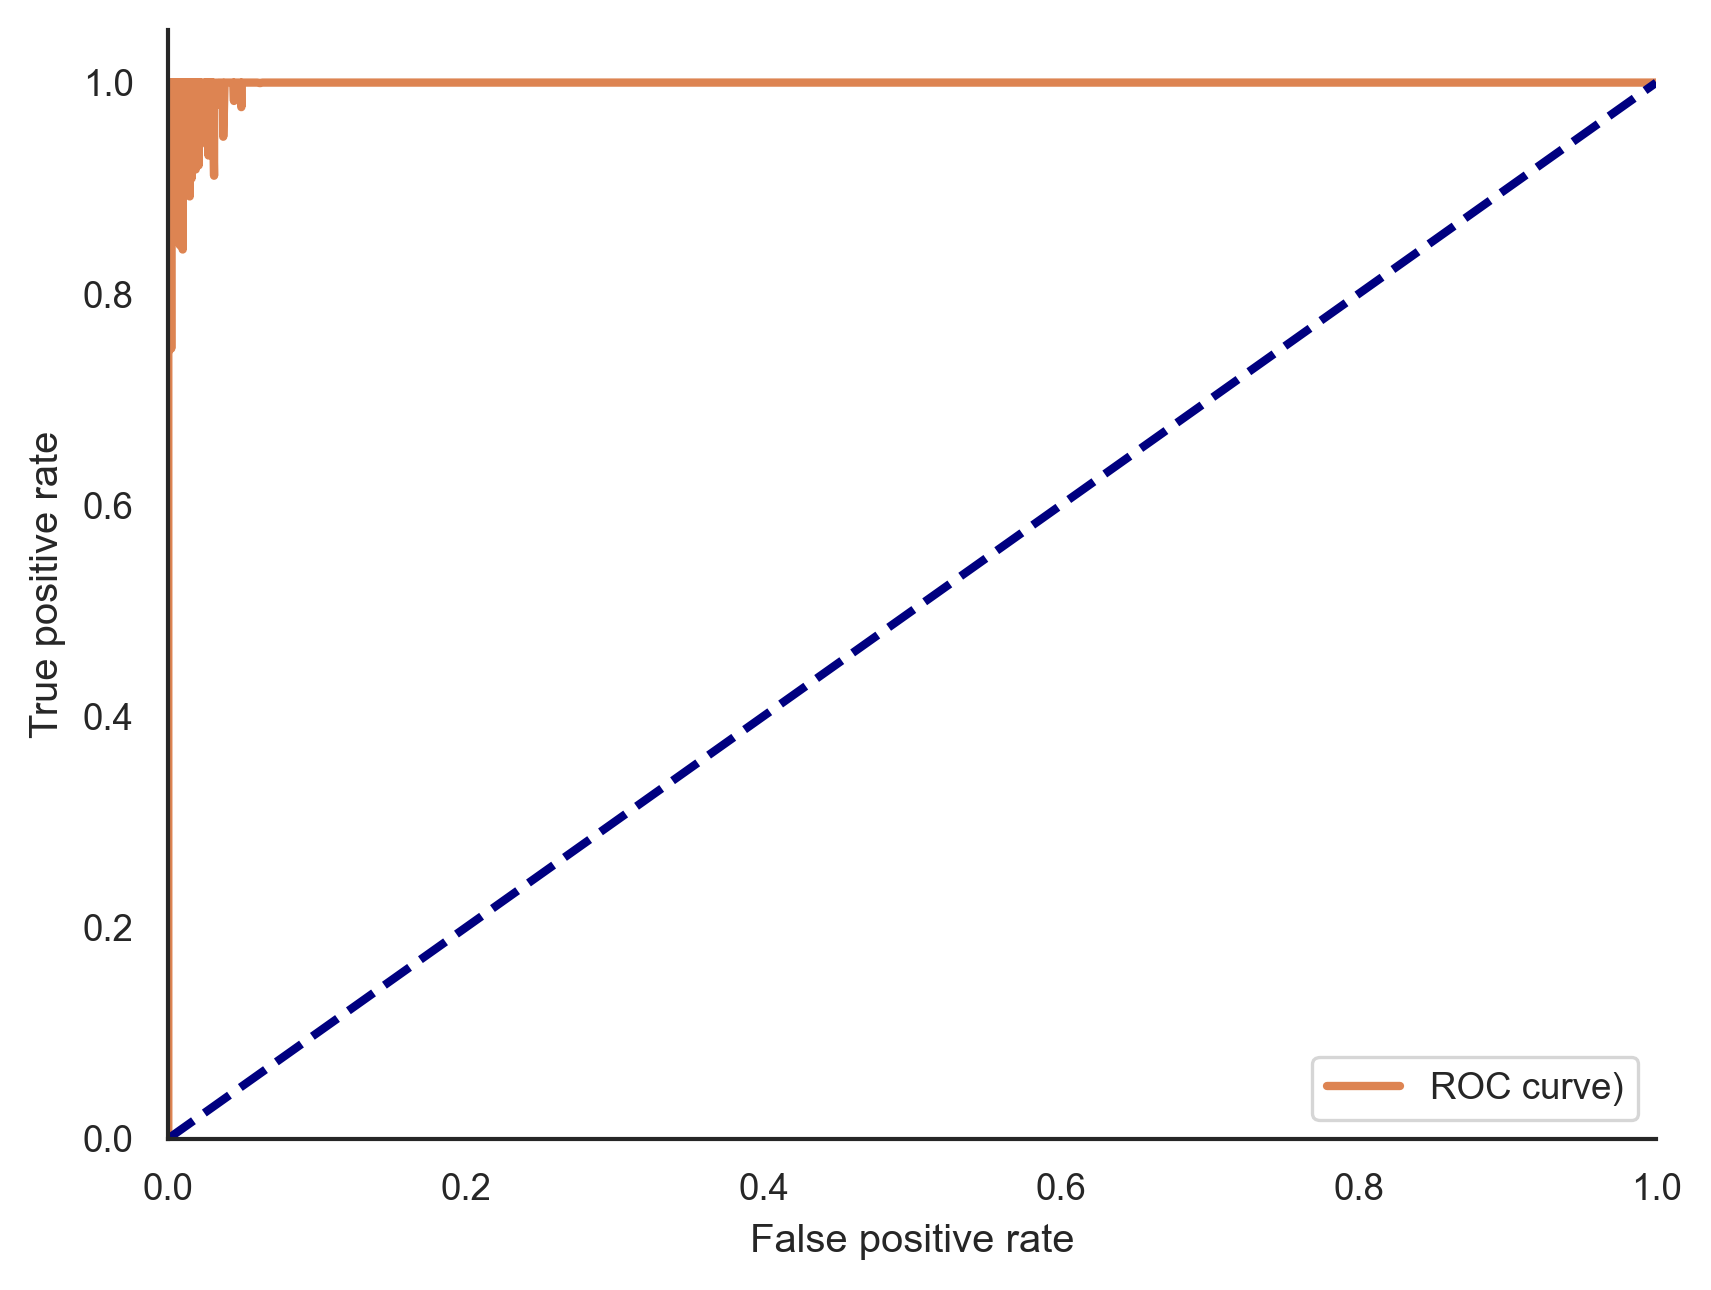

In [33]:
# Plot TPR vs FPR curve for each sample

roc_auc = auc(lst_fpr, lst_tpr)

# Plot the ROC curve
plt.plot(lst_fpr, lst_tpr, color=color_2, lw=2, label=f'ROC curve)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for each sample')
sns.despine()
plt.legend(loc='lower right')
plt.show()


---
# Revised version
#### ROC curve in log scale

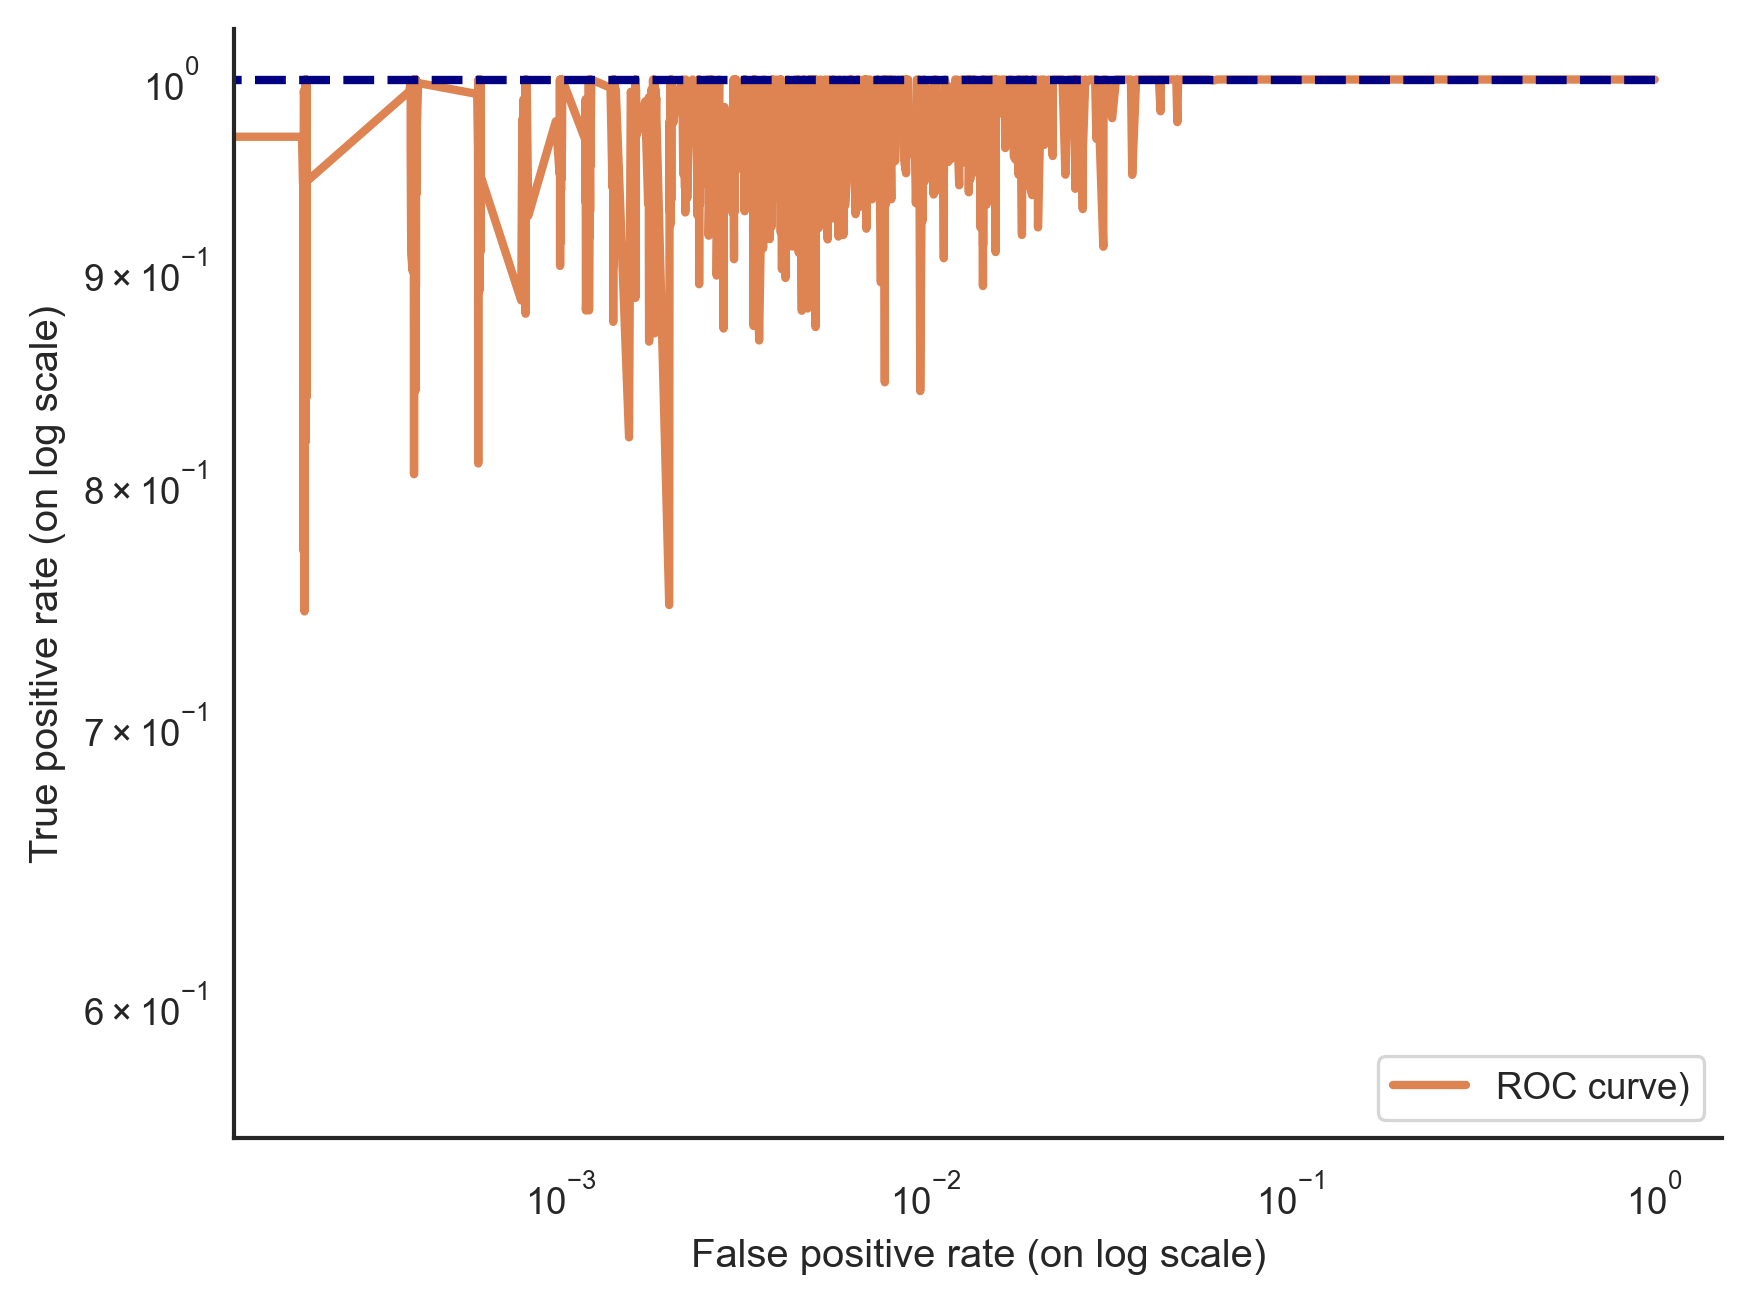

In [11]:
# df_roc['lg_fpr'] = np.log10(df_roc['fpr'] + 1e-10)
df_roc.sort_values(by='fpr', inplace=True)
# print(df_roc['fpr'])
# print(df_roc['tpr'])
# print(df_roc['tpr'])
# Calculate the AUC (Area Under the Curve)
# roc_auc = auc(df_roc['fpr'],df_roc['tpr'] )
lst_fpr = list(df_roc['fpr'].values)
lst_tpr = list(df_roc['tpr'].values)

lst_fpr.insert(0,0)
lst_fpr.append(1)

lst_tpr.insert(0,0)
lst_tpr.append(1)



# Plot TPR vs FPR curve for each sample

roc_auc = auc(lst_fpr, lst_tpr)

# Plot the ROC curve
plt.plot(lst_fpr, lst_tpr, color=color_2, lw=2, label=f'ROC curve)')
plt.plot([1, 0], [1, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
plt.yscale("log")
plt.xscale("log")

plt.xlabel('False positive rate (on log scale)')
plt.ylabel('True positive rate (on log scale)')
# plt.title('Receiver Operating Characteristic (ROC) Curve for each sample')
plt.legend(loc='lower right')
sns.despine()
plt.show()



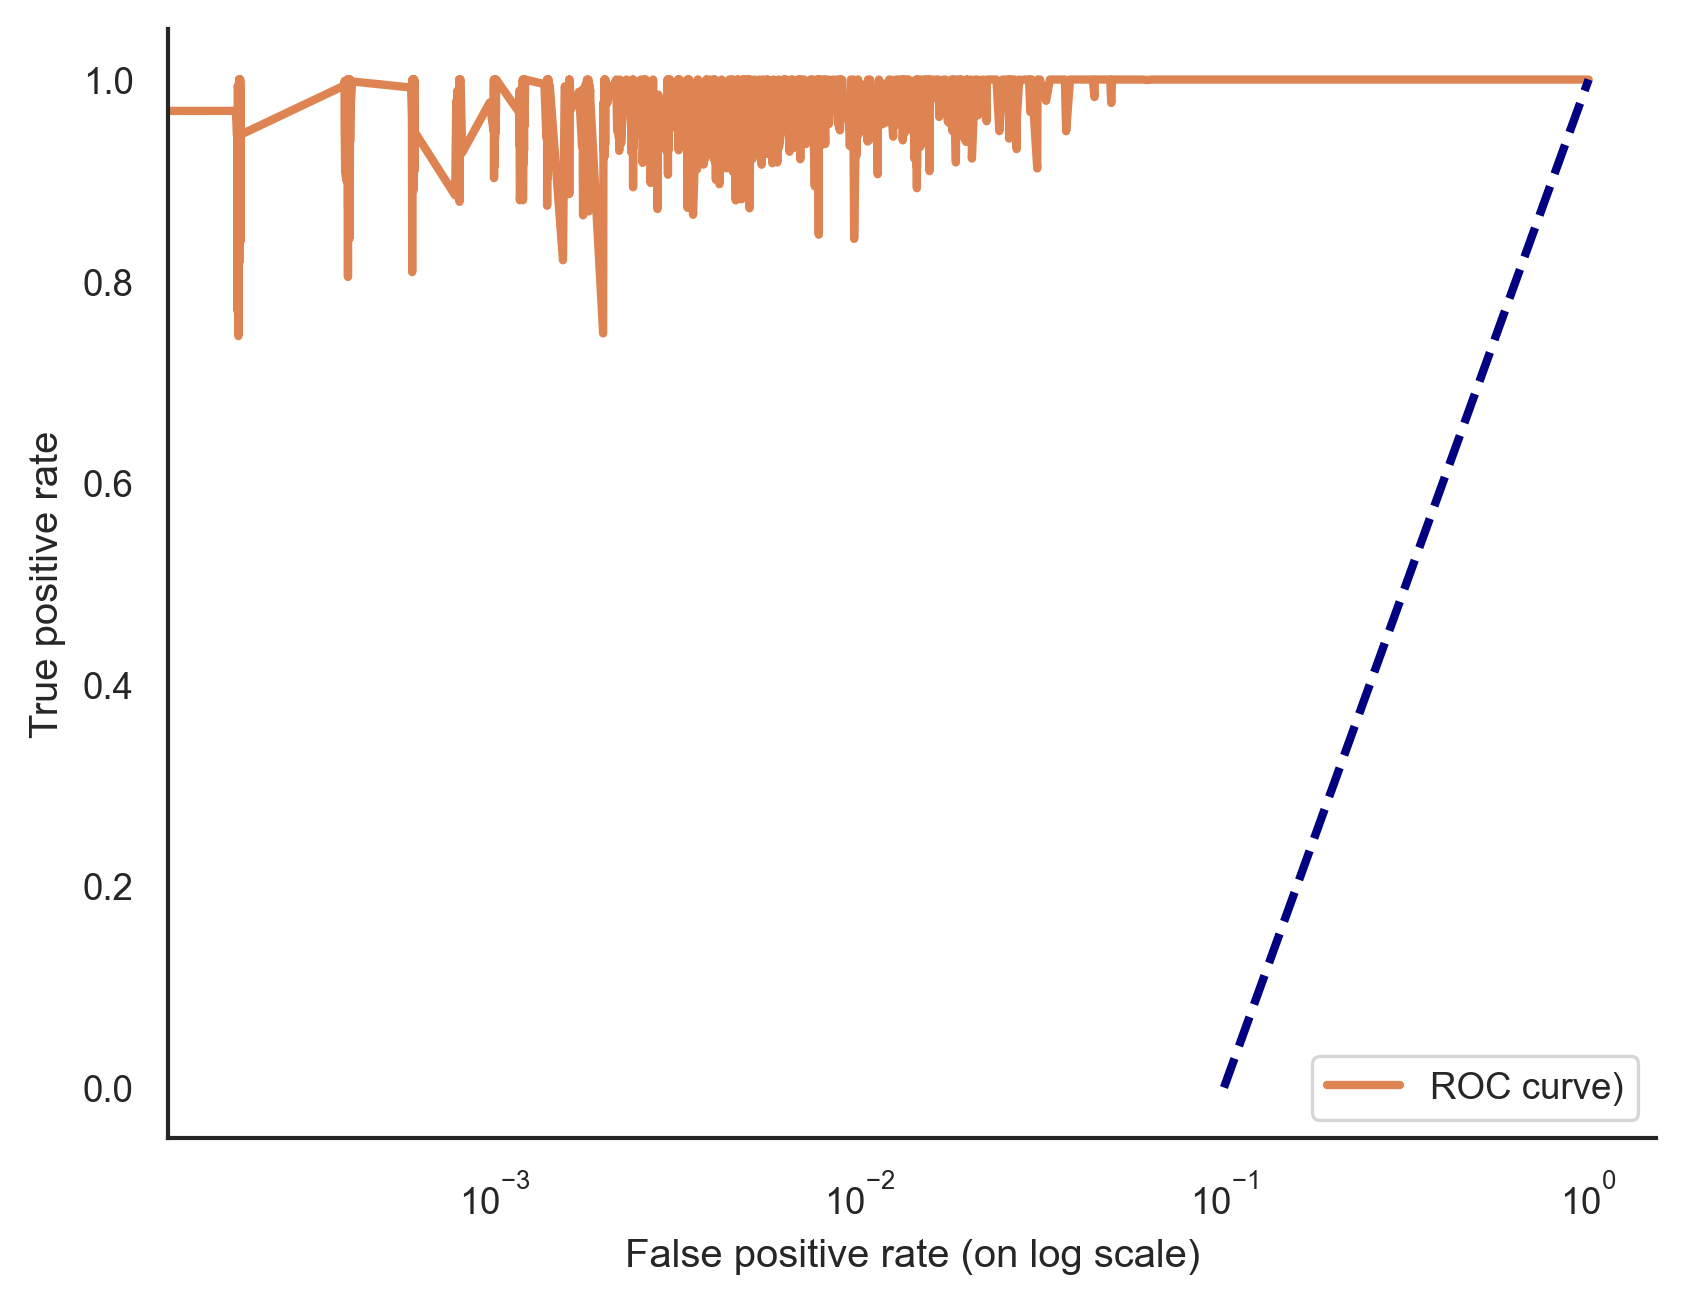

In [16]:
# df_roc['lg_fpr'] = np.log10(df_roc['fpr'] + 1e-10)
df_roc.sort_values(by='fpr', inplace=True)
# print(df_roc['fpr'])
# print(df_roc['tpr'])
# print(df_roc['tpr'])
# Calculate the AUC (Area Under the Curve)
# roc_auc = auc(df_roc['fpr'],df_roc['tpr'] )
lst_fpr = list(df_roc['fpr'].values)
lst_tpr = list(df_roc['tpr'].values)

lst_fpr.insert(0,0)
lst_fpr.append(1)

lst_tpr.insert(0,0)
lst_tpr.append(1)



# Plot TPR vs FPR curve for each sample

roc_auc = auc(lst_fpr, lst_tpr)

# Plot the ROC curve
plt.plot(lst_fpr, lst_tpr, color=color_2, lw=2, label=f'ROC curve)')
plt.plot([1e-1, 1], [1e-5, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([-0.05, 1.0])
# plt.ylim([0.0, 1.05])
# plt.yscale("log")
plt.xscale("log")

plt.xlabel('False positive rate (on log scale)')
plt.ylabel('True positive rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for each sample')
plt.legend(loc='lower right')
sns.despine()
plt.show()